# **Problem Formulation**
**Objective:**

To predict the variable
N (Number of Taps) at London Underground stations using machine learning models, with a specific focus on the XGBoost Regressor, and to evaluate the performance of these models for time-series forecasting.


**Background:**

There are a number of factors that affect the volume of taps or exits from each station in London Underground's complex transit system.Understanding these patterns is crucial for optimizing station management and public transportation planning.  To make a complete view of the system, this data set is composed of several aspects that include lockdown periods, station attributes and time series.

## **Dataset:**

The dataset, derived from Transport for London's Oyster and Contactless ticketing databases, is a detailed record of tube station interactions. It records daily arrivals and exits at each tube station in 15-minute intervals from January 1, 2020 through April 30, 2021. It tracks the commencement and duration of national and regional lockdowns, as well as mandatory closures of non-essential retail, pubs/restaurants, and schools.The dataset provides a detailed overview of numerous attributes, from everyday activities and lockdown regulations to information about train terminals.

### **MACHINE LEARNING PIPELINE**
Data Preprocessing: Handling missing values, encode categorical variables, and perform feature scaling.

Feature Engineering: Creating lag features for 7 days, 14-days, 21 days.

Model Selection: Using XGBoost Regressor as the primary model, and compare its performance with other machine learning models like Random Forest, Linear Regression, and SVM.

Training and Validation: Splitting the dataset into training, validation, and test sets considering the time-series nature of the data. Use metrics like RMSE, MAE, and R-squared for evaluation.

Hyperparameter Tuning: Optimize model parameters using techniques like Random Search.

Evaluation: Assess model performance on the test set and compare the results across different models.

In [60]:
import pandas as pd
import pickle
import json
import numpy as np
import seaborn as sns
from math import ceil
import pickle
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import r2_score
import os
from collections import Counter
import string
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import datetime

#### **Features Description:**

1.   <small>
CALENDARDATE: A character field representing the date of the event, formatted as '%d/%m/%Y'.
</small>
2.   <small>DOW: A character field indicating the Day of the Week.</small>

1.  <small> NLC: An integer field for the National Location Code, with values ranging from 500 to 6960.
</small>

1.   <small>SUBSYSTEM: A character field identifying the subsystem of rail taps received, set to 'LU' for London Underground.</small>

1.    <small>HOUR: A numeric field denoting the quarter-hour of the day, expressed as a decimal (e.g., 9.25 represents the period from 0915 to 0930 hrs)</small>

1.    <small>ENTRYEXIT: A character field indicating the direction of travel through the gateline, either 'ENTRY' for in or 'EXIT' for out.</small>
2.    <small>N: An integer field representing the number of taps during the 15-minute period.</small>


2.    <small>LOCKDOWN_NATIONAL and LOCKDOWN_REGIONAL: Indicate the status of national and regional lockdowns, respectively.</small>


2.    <small>SHOPS_CLOSED, PUBS_CLOSED, and SCHOOLS_CLOSED: Represent the closure status of various public establishments.</small>

2.    <small>NLC: An integer field indicating the National Location Code for each station.</small>

1.    <small>STATIONNAME: A character field providing the name of the station.</small>

1.    <small>MODE: A character field set to 'LU,' indicating the dataset is specific to the London Underground.</small>

1.     <small>BOROUGH: A character field specifying the borough, typically within the Greater London Area, where the station is located.</small>
2.    <small>STATIONTYPE: A character field classifying stations into various types like Shopping, City, Termini, and Inner/Outer Suburb.</small>

2.     <small>NAPTAN: A character field used as an alternative reference for the station, often used in TfL's Journey Planner API.</small>

2.     <small>QHR: A numeric field that represents the specific fifteen-minute interval of interest. This column sometimes aligns with the "HOUR" field in other related datasets.</small>

1. <small>PERIOD: A character field that identifies which three-hour block the given QHR falls into, with considerations for AM and PM peak periods, particularly valid on weekdays.</small>
2.  <small>The dataset enriches National Location Codes (NLC) with spatial and fare zone information for tube stations. It includes X and Y coordinates in a specialized system, a three-letter station code, fare zone, and geographical latitude and longitude.</small>


In [62]:
merge_data= pd.read_csv('./tfl_merge_cpldata.csv')

In [33]:
merge_data.head()

,CALENDARDATE,DOW,NLC,SUBSYSTEM,HOUR,ENTRYEXIT,N,CODE,ZONE,LAT,...,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,MODE,BOROUGH,STATIONTYPE,NAPTAN,PERIOD
0,2020-02-02,SUN,501,LU,6.75,Entry,10,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,EM (0400-0700)
1,2020-02-02,SUN,501,LU,6.75,Exit,17,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,EM (0400-0700)
2,2020-02-02,SUN,501,LU,7.00,Entry,16,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)
3,2020-02-02,SUN,501,LU,7.00,Exit,12,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)
4,2020-02-02,SUN,501,LU,7.25,Entry,13,BAR,1.0,51.5202,...,0,0,0,0,Barbican,LU,City of London,City,940GZZLUBBN,AM (0700-1000)


In [34]:
merge_data.isnull().any()

CALENDARDATE         False
DOW                  False
NLC                  False
SUBSYSTEM            False
HOUR                 False
ENTRYEXIT            False
N                    False
CODE                 False
ZONE                 False
LAT                  False
LONG                 False
LOCKDOWN_NATIONAL    False
LOCKDOWN_REGIONAL    False
SHOPS_CLOSED         False
PUBS_CLOSED          False
SCHOOLS_CLOSED       False
STATIONNAME          False
MODE                 False
BOROUGH              False
STATIONTYPE          False
NAPTAN               False
PERIOD               False
dtype: bool

In [165]:
data=merge_data.copy()

In [36]:
# del merge_data

In [81]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)

In [220]:
# Convert CALENDARDATE column to datetime type
merge_data['CALENDARDATE'] = pd.to_datetime(merge_data['CALENDARDATE'])

# Extract year and month names
merge_data['YEAR'] = merge_data['CALENDARDATE'].dt.year
merge_data['MONTH'] = merge_data['CALENDARDATE'].dt.strftime('%b%y')

# Calculate the average transaction for each month
monthly_avg_hypothetical = merge_data.groupby(['YEAR', 'MONTH'])['N'].sum()

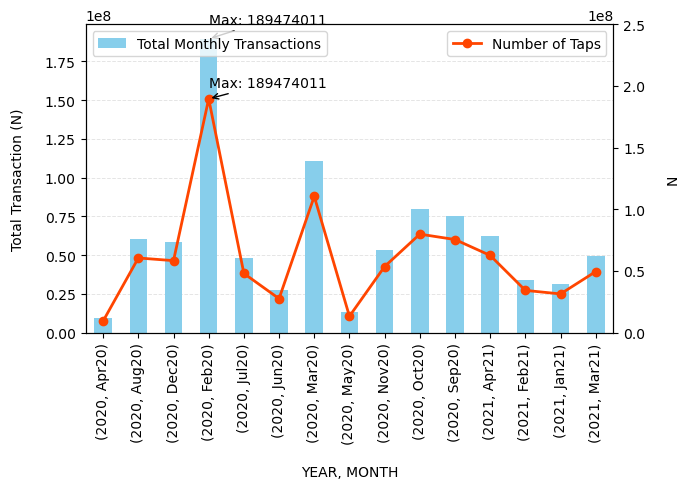

In [231]:
# Define colors and style for the plot
bar_color = '#A9A9A9'  # Gray color for bars
line_color = '#FF4500'  # Red color for the line
background_color = '#FFFFFF'  # White background
grid_color = '#D3D3D3'  # Light gray gridlines

# Plot the total transaction for each month with a red line representing the number of taps
plt.figure(figsize=(7, 5), facecolor=background_color)
ax = plt.gca()
ax.set_facecolor(background_color)

# Bar plot for total transactions
monthly_avg_hypothetical.plot(kind='bar', color='skyblue', label='Total Monthly Transactions', ax=ax)

# Line plot for number of taps
ax2 = ax.twinx()
monthly_avg_hypothetical.plot(kind='line', color=line_color, marker='o', label='Number of Taps', linewidth=2, ax=ax2)

# Get the coordinates for the point with the highest transaction value
highest_transaction_value = monthly_avg_hypothetical.max()
highest_transaction_index = monthly_avg_hypothetical.idxmax()
highest_transaction_plot_index = monthly_avg_hypothetical.index.get_loc(highest_transaction_index)

# Annotate the highest point on the graph for the bar plot
ax.annotate(f"Max: {highest_transaction_value}", 
            xy=(highest_transaction_plot_index, highest_transaction_value), 
            xytext=(highest_transaction_plot_index, highest_transaction_value + 0.05 * highest_transaction_value),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Annotate the highest point on the graph for the line plot
ax2.annotate(f"Max: {highest_transaction_value}", 
             xy=(highest_transaction_plot_index, highest_transaction_value), 
             xytext=(highest_transaction_plot_index, highest_transaction_value + 0.05 * highest_transaction_value),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

# Set labels, legends, and gridlines
# ax.set_title('Monthly Variations: Total Transactions vs. Number of Taps', fontsize=16, pad=20)
ax.set_xlabel('YEAR, MONTH', labelpad=15)
ax.set_ylabel('Total Transaction (N)', labelpad=15)
ax2.set_ylabel('N', labelpad=15)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(axis='y', color=grid_color, linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_axisbelow(True)
plt.ylim(0, 250000000)
plt.tight_layout()
plt.savefig('./Monthly Variations Total Transactions vs. Number of Taps.PNG',  bbox_inches='tight', dpi=300)
plt.show()

# Period weekdays

In [166]:
data.DOW.value_counts()

WED    2545766
TUE    2541172
THU    2538808
MON    2528580
FRI    2490464
SAT    2386870
SUN    2222998
Name: DOW, dtype: int64

In [112]:
# Filtering data for Weekdays (Monday to Friday)
df_weekdays = data[data['DOW'].isin(['MON', 'TUE', 'WED', 'THU', 'FRI'])]

In [120]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_WEEKDAYS = df_weekdays.groupby(['CALENDARDATE','DOW', 'LOCKDOWN_REGIONAL','PERIOD'])['N'].sum().reset_index()

aggregated_WEEKDAYS.head(10)

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N
0,2020-02-03,MON,0,AM (0700-1000),2030918
1,2020-02-03,MON,0,EM (0400-0700),285535
2,2020-02-03,MON,0,EV (1900-2200),889466
3,2020-02-03,MON,0,IP1 (1000-1300),880120
4,2020-02-03,MON,0,IP2 (1300-1600),979134
5,2020-02-03,MON,0,NT1 (2200-0100),271273
6,2020-02-03,MON,0,NT2 (0100-0400),960
7,2020-02-03,MON,0,PM (1600-1900),2132749
8,2020-02-04,TUE,0,AM (0700-1000),2152224
9,2020-02-04,TUE,0,EM (0400-0700),295061


In [125]:
avg_weekdays_lockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '1']

In [126]:
avg_weekdays_lockdowntaps

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N
280,2020-03-23,MON,1,AM (0700-1000),302217
281,2020-03-23,MON,1,EM (0400-0700),121758
282,2020-03-23,MON,1,EV (1900-2200),101243
283,2020-03-23,MON,1,IP1 (1000-1300),121943
284,2020-03-23,MON,1,IP2 (1300-1600),160956
...,...,...,...,...,...
2480,2021-04-12,MON,1,IP1 (1000-1300),348002
2481,2021-04-12,MON,1,IP2 (1300-1600),431811
2482,2021-04-12,MON,1,NT1 (2200-0100),94321
2483,2021-04-12,MON,1,NT2 (0100-0400),530


In [150]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_lockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),315382.112903
1,1,EM (0400-0700),102404.161290
2,1,EV (1900-2200),122971.491935
3,1,IP1 (1000-1300),152242.830645
4,1,IP2 (1300-1600),210441.653226
5,1,NT1 (2200-0100),33202.596774
6,1,NT2 (0100-0400),303.290323
7,1,PM (1600-1900),350347.750000


In [151]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_nonlockdowntaps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_nonlockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_nonlockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,0,AM (0700-1000),682426.210227
1,0,EM (0400-0700),149221.602273
2,0,EV (1900-2200),364748.477273
3,0,IP1 (1000-1300),370355.403409
4,0,IP2 (1300-1600),451386.136364
5,0,NT1 (2200-0100),142435.056818
6,0,NT2 (0100-0400),3498.079545
7,0,PM (1600-1900),797305.517045


In [152]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier2taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier2taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier2taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier2,AM (0700-1000),608812.9
1,Tier2,EM (0400-0700),148267.9
2,Tier2,EV (1900-2200),348561.1
3,Tier2,IP1 (1000-1300),372704.8
4,Tier2,IP2 (1300-1600),483439.4
5,Tier2,NT1 (2200-0100),153827.5
6,Tier2,NT2 (0100-0400),599.2
7,Tier2,PM (1600-1900),756580.0


In [153]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier3taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier3taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier3taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier3,AM (0700-1000),502027.666667
1,Tier3,EM (0400-0700),133821.666667
2,Tier3,EV (1900-2200),262330.666667
3,Tier3,IP1 (1000-1300),333365.333333
4,Tier3,IP2 (1300-1600),435381.666667
5,Tier3,NT1 (2200-0100),71922.000000
6,Tier3,NT2 (0100-0400),512.333333
7,Tier3,PM (1600-1900),597845.000000


In [154]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekdays_Tier4taps = aggregated_WEEKDAYS[aggregated_WEEKDAYS['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekdays_Tier4taps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekdays_Tier4taps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier4,AM (0700-1000),173071.636364
1,Tier4,EM (0400-0700),59525.300000
2,Tier4,EV (1900-2200),105949.000000
3,Tier4,IP1 (1000-1300),136317.909091
4,Tier4,IP2 (1300-1600),186335.727273
5,Tier4,NT1 (2200-0100),34595.500000
6,Tier4,NT2 (0100-0400),281.181818
7,Tier4,PM (1600-1900),219583.000000


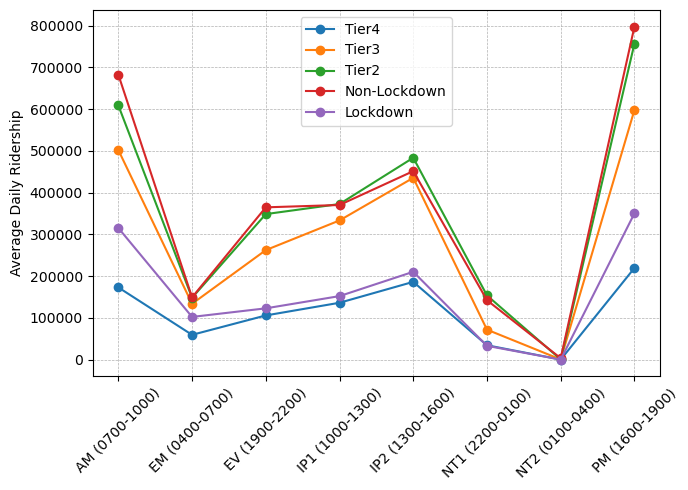

In [232]:
# Combining dataframes for easier plotting
combined_dataframes = {
    "Tier4": avg_weekdays_Tier4taps,
    "Tier3": avg_weekdays_Tier3taps,
    "Tier2": avg_weekdays_Tier2taps,
    "Non-Lockdown": avg_weekdays_nonlockdowntaps,
    "Lockdown": avg_weekdays_lockdowntaps
}

# Plotting the data
plt.figure(figsize=(7,5))
for lockdown_type, data in combined_dataframes.items():
    plt.plot(data["PERIOD"], data["AVERRAGE(N)"], label=lockdown_type, marker='o')

# plt.xlabel("PERIOD")
plt.ylabel("Average Daily Ridership")
#     plt.title("Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('./Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London.png',  bbox_inches='tight',dpi=300)
plt.show()


In [176]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)
# Filtering data for Weekdays (Monday to Friday)
df_weekENDS = data[data['DOW'].isin(['SAT','SUN'])]
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_weekENDS = df_weekENDS.groupby(['CALENDARDATE','DOW', 'LOCKDOWN_REGIONAL','PERIOD'])['N'].sum().reset_index()

In [174]:
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1']

In [175]:
data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)

,CALENDARDATE,DOW,LOCKDOWN_REGIONAL,PERIOD,N


In [177]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

avg_weekENDS_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),91358.122449
1,1,EM (0400-0700),30071.081633
2,1,EV (1900-2200),84716.326531
3,1,IP1 (1000-1300),121755.795918
4,1,IP2 (1300-1600),176531.979592
5,1,NT1 (2200-0100),29828.836735
6,1,NT2 (0100-0400),185.775510
7,1,PM (1600-1900),156153.530612


In [178]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_lockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_lockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_NONlockdowntaps = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_NONlockdowntaps.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier2 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier2.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier3 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier3.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
avg_weekENDS_Tier4 = aggregated_weekENDS[aggregated_weekENDS['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL','PERIOD'])['N'].mean().reset_index()

# Rename the 'N' column to 'Average_Taps'
avg_weekENDS_Tier4.columns = ['LOCKDOWN_REGIONAL','PERIOD', 'AVERRAGE(N)']

In [183]:
avg_weekENDS_lockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,1,AM (0700-1000),91358.122449
1,1,EM (0400-0700),30071.081633
2,1,EV (1900-2200),84716.326531
3,1,IP1 (1000-1300),121755.795918
4,1,IP2 (1300-1600),176531.979592
5,1,NT1 (2200-0100),29828.836735
6,1,NT2 (0100-0400),185.775510
7,1,PM (1600-1900),156153.530612


In [184]:
avg_weekENDS_NONlockdowntaps

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,0,AM (0700-1000),189542.457143
1,0,EM (0400-0700),44313.214286
2,0,EV (1900-2200),267488.257143
3,0,IP1 (1000-1300),348183.814286
4,0,IP2 (1300-1600),439341.385714
5,0,NT1 (2200-0100),128754.842857
6,0,NT2 (0100-0400),9459.642857
7,0,PM (1600-1900),432880.457143


In [185]:
avg_weekENDS_Tier2

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier2,AM (0700-1000),205771.25
1,Tier2,EM (0400-0700),44958.50
2,Tier2,EV (1900-2200),300373.00
3,Tier2,IP1 (1000-1300),407483.50
4,Tier2,IP2 (1300-1600),555792.00
5,Tier2,NT1 (2200-0100),150472.50
6,Tier2,NT2 (0100-0400),532.50
7,Tier2,PM (1600-1900),548195.50


In [186]:
avg_weekENDS_Tier3

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier3,AM (0700-1000),205366.0
1,Tier3,EM (0400-0700),55273.0
2,Tier3,EV (1900-2200),234334.0
3,Tier3,IP1 (1000-1300),311879.0
4,Tier3,IP2 (1300-1600),439566.0
5,Tier3,NT1 (2200-0100),77849.0
6,Tier3,NT2 (0100-0400),602.0
7,Tier3,PM (1600-1900),414502.0


In [187]:
avg_weekENDS_Tier4

,LOCKDOWN_REGIONAL,PERIOD,AVERRAGE(N)
0,Tier4,AM (0700-1000),69813.6
1,Tier4,EM (0400-0700),16406.2
2,Tier4,EV (1900-2200),79392.8
3,Tier4,IP1 (1000-1300),105742.6
4,Tier4,IP2 (1300-1600),160834.8
5,Tier4,NT1 (2200-0100),28419.4
6,Tier4,NT2 (0100-0400),158.6
7,Tier4,PM (1600-1900),145060.4


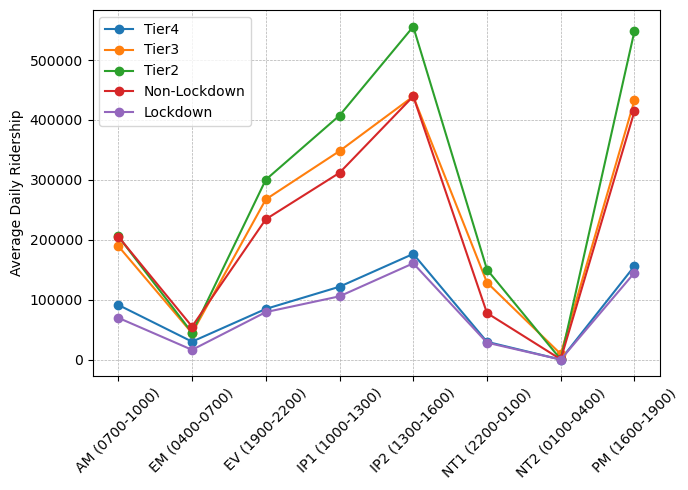

In [233]:
# Combining dataframes for easier plotting
combined_dataframes = {
    "Tier4": avg_weekENDS_lockdowntaps,
    "Tier3": avg_weekENDS_NONlockdowntaps,
    "Tier2": avg_weekENDS_Tier2,
    "Non-Lockdown": avg_weekENDS_Tier3,
    "Lockdown": avg_weekENDS_Tier4
}

# Plotting the data
plt.figure(figsize=(7,5))
for lockdown_type, data in combined_dataframes.items():
    plt.plot(data["PERIOD"], data["AVERRAGE(N)"], label=lockdown_type, marker='o')

# plt.xlabel("PERIOD")
plt.ylabel("Average Daily Ridership")
#     plt.title("Average Daily Riding Patterns on the Tube During Weekdays Across Lockdown Phases in London")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('./Average Daily Riding Patterns on the Tube During WeekENDs Across Lockdown Phases in London.png',  bbox_inches='tight',dpi=300)
plt.show()


# Lockdown Regional

In [82]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_df = data.groupby(['CALENDARDATE', 'LOCKDOWN_REGIONAL','STATIONTYPE'])['N'].sum().reset_index()

# Rename columns for clarity
aggregated_df.columns = ['CALENDARDATE','LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']

aggregated_df.head()

,CALENDARDATE,LOCKDOWN_REGIONAL,STATIONTYPE,N
0,2020-02-02,0,Airport,27
1,2020-02-02,0,City,238185
2,2020-02-02,0,Inner Suburb,1035229
3,2020-02-02,0,Outer Suburb,825567
4,2020-02-02,0,Shopping,470260


In [83]:
data['LOCKDOWN_REGIONAL'].value_counts()

0        9542853
1        6401580
Tier2     576817
Tier4     567849
Tier3     165559
Name: LOCKDOWN_REGIONAL, dtype: int64

In [89]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_lockdown = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == '1'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_lockdown.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution']= (daily_taps_lockdown['N'] / total_N * 100).round(2)
daily_taps_lockdown

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.35
1,1,City,11947258,6.18
2,1,Inner Suburb,58202352,30.08
3,1,Outer Suburb,66620743,34.44
4,1,Shopping,17719665,9.16
5,1,Terminus,24937838,12.89
6,1,Tourist,13366526,6.91


In [91]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_notlockdown = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == '0'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_notlockdown.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution']= (daily_taps_notlockdown['N'] / total_N * 100).round(2)
daily_taps_notlockdown

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,0,Airport,2669639,0.41
1,0,City,54261699,8.33
2,0,Inner Suburb,176284908,27.06
3,0,Outer Suburb,179551530,27.56
4,0,Shopping,77511221,11.90
5,0,Terminus,101868884,15.64
6,0,Tourist,59251865,9.10


In [95]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier2 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier2'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier2.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier2['N'].sum()
# Calculate relative percentage change
daily_taps_Tier2['percentage_contribution']= (daily_taps_Tier2['N'] / total_N * 100).round(2)
daily_taps_Tier2

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier2,Airport,111169,0.30
1,Tier2,City,2410098,6.41
2,Tier2,Inner Suburb,10670239,28.39
3,Tier2,Outer Suburb,10855681,28.89
4,Tier2,Shopping,5139847,13.68
5,Tier2,Terminus,5057740,13.46
6,Tier2,Tourist,3337469,8.88


In [96]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier3 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier3'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier3.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier3['N'].sum()
# Calculate relative percentage change
daily_taps_Tier3['percentage_contribution']= (daily_taps_Tier3['N'] / total_N * 100).round(2)
daily_taps_Tier3

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier3,Airport,43616,0.50
1,Tier3,City,527696,6.03
2,Tier3,Inner Suburb,2493912,28.50
3,Tier3,Outer Suburb,2694965,30.80
4,Tier3,Shopping,1198167,13.69
5,Tier3,Terminus,1136922,12.99
6,Tier3,Tourist,655712,7.49


In [97]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_Tier4 = aggregated_df[aggregated_df['LOCKDOWN_REGIONAL'] == 'Tier4'].groupby(['LOCKDOWN_REGIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_Tier4.columns = ['LOCKDOWN_REGIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_Tier4['N'].sum()
# Calculate relative percentage change
daily_taps_Tier4['percentage_contribution']= (daily_taps_Tier4['N'] / total_N * 100).round(2)
daily_taps_Tier4

,LOCKDOWN_REGIONAL,STATIONTYPE,N,percentage_contribution
0,Tier4,Airport,71359,0.55
1,Tier4,City,749227,5.81
2,Tier4,Inner Suburb,3925420,30.43
3,Tier4,Outer Suburb,4355428,33.76
4,Tier4,Shopping,1256526,9.74
5,Tier4,Terminus,1656767,12.84
6,Tier4,Tourist,886597,6.87


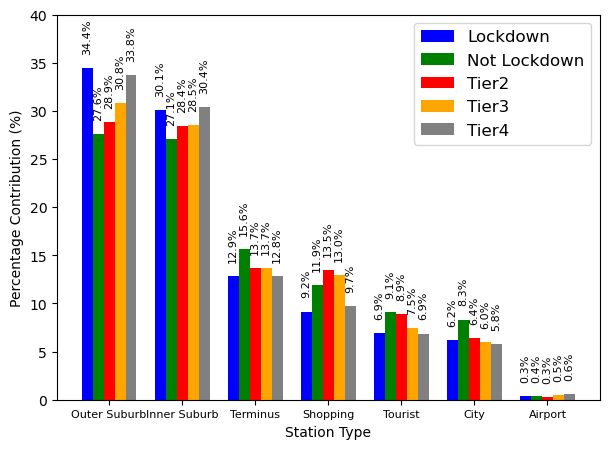

In [239]:
import matplotlib.pyplot as plt

# Define necessary variables for plotting
bar_width = 0.15
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))
positions = [index + i*bar_width for i in range(5)]

# Sorting the dataframes based on 'percentage_contribution' in descending order for better visualization
daily_taps_lockdown = daily_taps_lockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_notlockdown = daily_taps_notlockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier2 = daily_taps_Tier2.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier3 = daily_taps_Tier3.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_Tier4 = daily_taps_Tier4.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
def annotate_bars(bars, ax, spacing=10):
    for bar in bars:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        va = 'bottom'
        ax.annotate(
             f"{y_value:.1f}%",
            (x_value, y_value),
            xytext=(0, spacing),
            textcoords="offset points",
            ha='center',
            va=va,
            fontsize=8,
            rotation=90
        )
# Plotting
plt.figure(figsize=(7, 5))
ax = plt.gca()

# Define variables for plotting
bar_width = 0.15
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))
positions = [index + i*bar_width for i in range(5)]

# Plotting bars for all dataframes
bars_lockdown = plt.bar(positions[0], daily_taps_lockdown['percentage_contribution'], bar_width, label='Lockdown', color='blue')
bars_notlockdown = plt.bar(positions[1], daily_taps_notlockdown['percentage_contribution'], bar_width, label='Not Lockdown', color='green')
bars_Tier2 = plt.bar(positions[2], daily_taps_Tier2['percentage_contribution'], bar_width, label='Tier2', color='red')
bars_Tier3 = plt.bar(positions[3], daily_taps_Tier3['percentage_contribution'], bar_width, label='Tier3', color='orange')
bars_Tier4 = plt.bar(positions[4], daily_taps_Tier4['percentage_contribution'], bar_width, label='Tier4', color='grey')

# Annotate the bars
annotate_bars(bars_lockdown, ax)
annotate_bars(bars_notlockdown, ax)
annotate_bars(bars_Tier2, ax)
annotate_bars(bars_Tier3, ax)
annotate_bars(bars_Tier4, ax)

plt.xlabel('Station Type')
plt.ylabel('Percentage Contribution (%)')
plt.xticks(index + 2*bar_width, daily_taps_lockdown['STATIONTYPE'],fontsize=8)  
plt.legend(fontsize=12)
plt.ylim(0,40)
#Uncomment the next line if you wish to save the figure
plt.savefig('./Percentage_Contribution_by_Station_type_during_Lockdown.png',  bbox_inches='tight',dpi=300)

plt.show()

# Lockdown National

In [64]:
# Group by 'CALENDARDATE' and 'STATIONTYPE' to get the sum of 'N' for each combination
aggregated_df = data.groupby(['CALENDARDATE', 'LOCKDOWN_NATIONAL','STATIONTYPE'])['N'].sum().reset_index()

# Rename columns for clarity
aggregated_df.columns = ['CALENDARDATE','LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']

aggregated_df.head()

,CALENDARDATE,LOCKDOWN_NATIONAL,STATIONTYPE,N
0,2020-02-02,0,Airport,27
1,2020-02-02,0,City,238185
2,2020-02-02,0,Inner Suburb,1035229
3,2020-02-02,0,Outer Suburb,825567
4,2020-02-02,0,Shopping,470260


In [72]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_lockdown = aggregated_df[aggregated_df['LOCKDOWN_NATIONAL'] == 1].groupby(['LOCKDOWN_NATIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_lockdown.columns = ['LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution']= (daily_taps_lockdown['N'] / total_N * 100).round(2)
daily_taps_lockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.35
1,1,City,11947258,6.18
2,1,Inner Suburb,58202352,30.08
3,1,Outer Suburb,66620743,34.44
4,1,Shopping,17719665,9.16
5,1,Terminus,24937838,12.89
6,1,Tourist,13366526,6.91


In [69]:
daily_taps_lockdown.Percentage

0     0.35
1     6.18
2    30.08
3    34.44
4     9.16
5    12.89
6     6.91
Name: Percentage, dtype: float64

In [73]:
# Group by 'LOCKDOWN_NATIONAL' and 'STATIONTYPE' to compute the average taps during a lockdown for each station type
daily_taps_notlockdown = aggregated_df[aggregated_df['LOCKDOWN_NATIONAL'] == 0].groupby(['LOCKDOWN_NATIONAL', 'STATIONTYPE'])['N'].sum().reset_index()

# Rename the 'N' column to 'Average_Taps'
daily_taps_notlockdown.columns = ['LOCKDOWN_NATIONAL', 'STATIONTYPE', 'N']
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution']= (daily_taps_notlockdown['N'] / total_N * 100).round(2)
daily_taps_notlockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,0,Airport,2895783,0.41
1,0,City,57948720,8.15
2,0,Inner Suburb,193374479,27.21
3,0,Outer Suburb,197457604,27.79
4,0,Shopping,85105761,11.98
5,0,Terminus,109720313,15.44
6,0,Tourist,64131643,9.02


In [71]:
daily_taps_notlockdown.Percentage

0     0.41
1     8.15
2    27.21
3    27.79
4    11.98
5    15.44
6     9.02
Name: Percentage, dtype: float64

In [40]:
daily_taps_lockdown

,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,1,Airport,669779,0.346203
1,1,City,11947258,6.175437
2,1,Inner Suburb,58202352,30.084307
3,1,Outer Suburb,66620743,34.435703
4,1,Shopping,17719665,9.159146
5,1,Terminus,24937838,12.890159
6,1,Tourist,13366526,6.909045


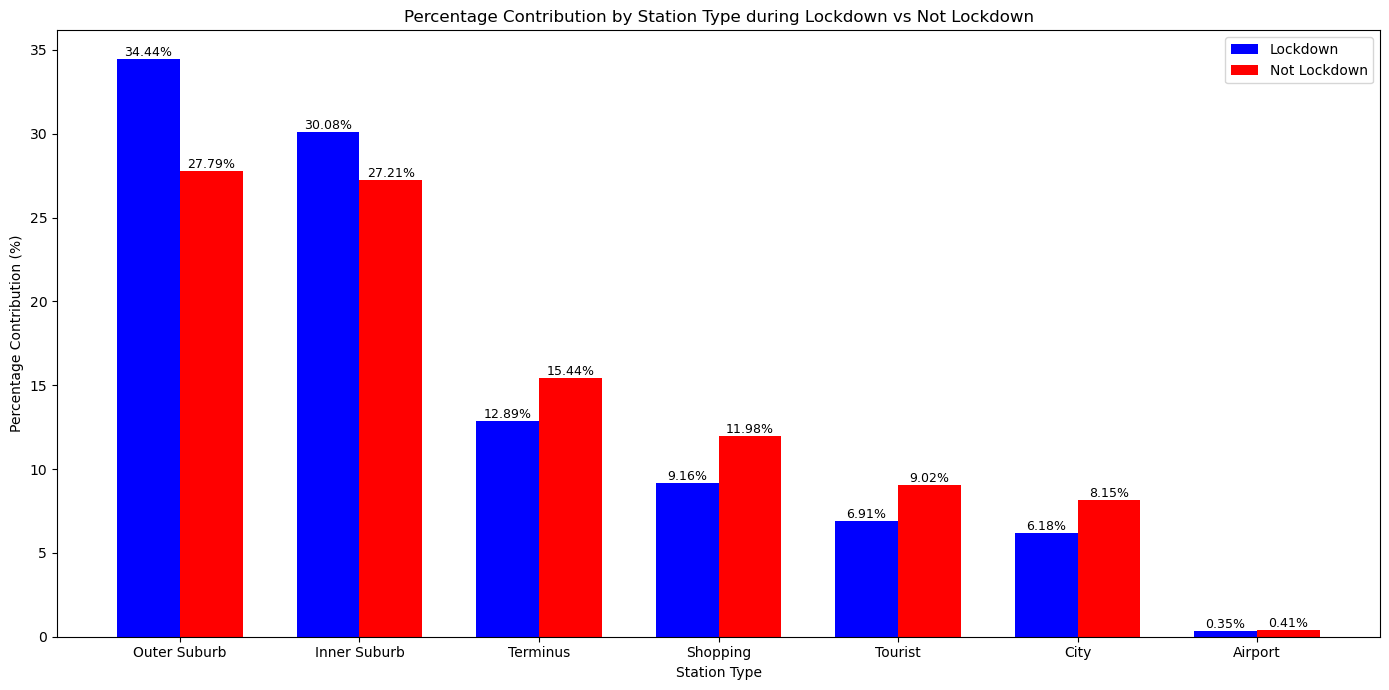

In [80]:
# Sorting the dataframes based on 'percentage_contribution' in descending order for better visualization
daily_taps_lockdown = daily_taps_lockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)
daily_taps_notlockdown = daily_taps_notlockdown.sort_values(by='percentage_contribution', ascending=False).reset_index(drop=True)


# Define necessary variables for plotting
bar_width = 0.35
index = np.arange(len(daily_taps_lockdown['STATIONTYPE']))

# Produce the combined bar plot
plt.figure(figsize=(14, 7))
# Plotting bars for lockdown and notlockdown data
bars_lockdown = plt.bar(index, daily_taps_lockdown['percentage_contribution'], bar_width, label='Lockdown', color='blue')
bars_notlockdown = plt.bar(index + bar_width, daily_taps_notlockdown['percentage_contribution'], bar_width, label='Not Lockdown', color='red')

# Function to annotate bars with their percentages
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.2f%%' % height, ha='center', va='bottom', fontsize=9)

# Annotating the bars with their percentages
annotate_bars(bars_lockdown)
annotate_bars(bars_notlockdown)
plt.xlabel('Station Type')
plt.ylabel('Percentage Contribution (%)')
plt.title('Percentage Contribution by Station Type during Lockdown vs Not Lockdown')
plt.xticks(index + bar_width / 2, daily_taps_lockdown['STATIONTYPE'])
plt.legend()
plt.tight_layout()
plt.savefig('./Percentage Contribution by Station type during Lockdown vs Not Lockdown.png',  bbox_inches='tight')
plt.show();

In [18]:
daily_taps_notlockdown=aggregated_df[aggregated_df['LOCKDOWN_NATIONAL']==0]
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution ']= (daily_taps_notlockdown['N']) / total_N * 100
daily_taps_notlockdown

,CALENDARDATE,LOCKDOWN_NATIONAL,STATIONTYPE,N,percentage_contribution
0,2020-02-02,0,Airport,27,0.000004
1,2020-02-02,0,City,238185,0.033517
2,2020-02-02,0,Inner Suburb,1035229,0.145677
3,2020-02-02,0,Outer Suburb,825567,0.116173
4,2020-02-02,0,Shopping,470260,0.066175
...,...,...,...,...,...
3160,2021-04-29,0,Inner Suburb,836368,0.117693
3161,2021-04-29,0,Outer Suburb,877436,0.123472
3162,2021-04-29,0,Shopping,322793,0.045423
3163,2021-04-29,0,Terminus,408617,0.057500


In [ ]:
daily_taps_notlockdown=average_taps[average_taps['LOCKDOWN_NATIONAL']==0]
total_N = daily_taps_notlockdown['N'].sum()
# Calculate relative percentage change
daily_taps_notlockdown['percentage_contribution ']= (daily_taps_notlockdown['N']) / total_N * 100

daily_taps_lockdown=average_taps[average_taps['LOCKDOWN_NATIONAL']==1]
total_N = daily_taps_lockdown['N'].sum()
# Calculate relative percentage change
daily_taps_lockdown['percentage_contribution ']= (daily_taps_lockdown['N']) / total_N * 100